In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the location dataset

data = "pickup_coord_data.csv"

df_reader = pd.read_csv(data, chunksize=100000)

df_reader

In [3]:
# do sampling

all_samples = []

df_reader = pd.read_csv(data, chunksize=100000)

for df in df_reader:
    all_samples.append(df.sample(500))


sample_df = pd.concat(all_samples, axis=0)

In [4]:
# size of sample df

sample_df.shape

(166500, 2)

In [5]:
sample_df.head()

,pickup_latitude,pickup_longitude
9353,40.728512,-73.999840
80166,40.714466,-73.935493
94104,40.777454,-73.900597
97144,40.756058,-73.978775
15518,40.766521,-73.996025


Text(0, 0.5, 'Longitude')

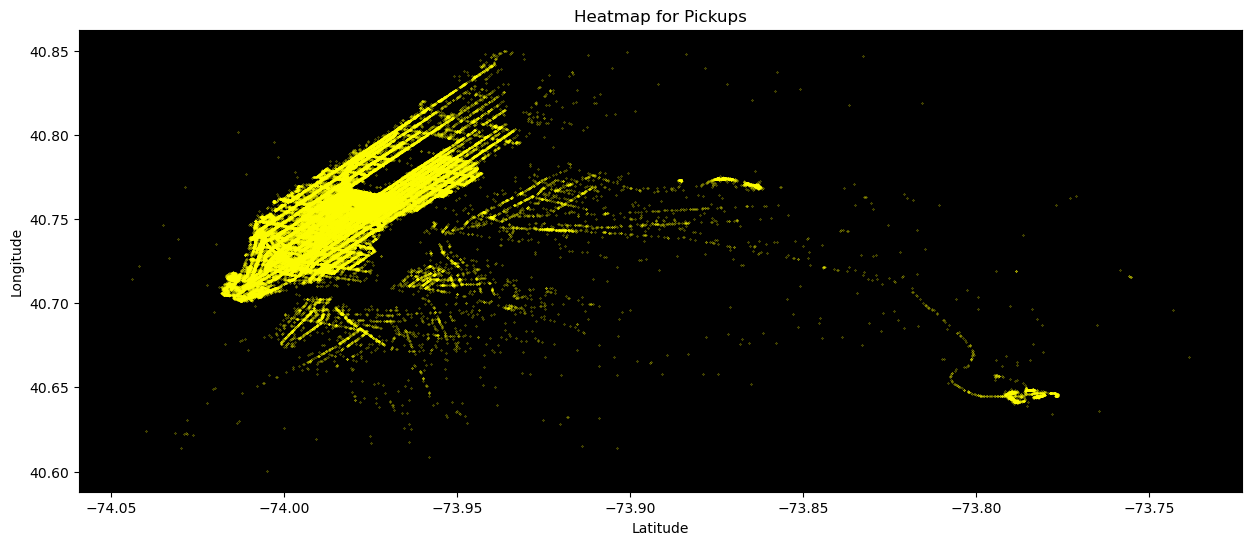

In [6]:
# plot the dataset on a scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,
                     figsize=(15,6))

ax.set_facecolor('k')
ax.scatter(sample_df['pickup_longitude'],sample_df['pickup_latitude'],s=0.05,color='yellow')
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

In [7]:
from sklearn import set_config

set_config(transform_output='pandas')

In [8]:
# scale the input columns

from sklearn.preprocessing import StandardScaler

scale_samples = StandardScaler()

scaled_sample_df = scale_samples.fit_transform(sample_df)

In [9]:
scaled_sample_df

,pickup_latitude,pickup_longitude
9353,-0.831123,-0.702452
80166,-1.346443,1.043095
94104,0.964516,1.989755
97144,0.179501,-0.131020
15518,0.563401,-0.598969
...,...,...
33230447,1.750931,0.594393
33215470,0.654653,3.015889
33212846,-0.198801,-0.341918
33200284,-0.120005,-0.819181


Text(0, 0.5, 'Longitude')

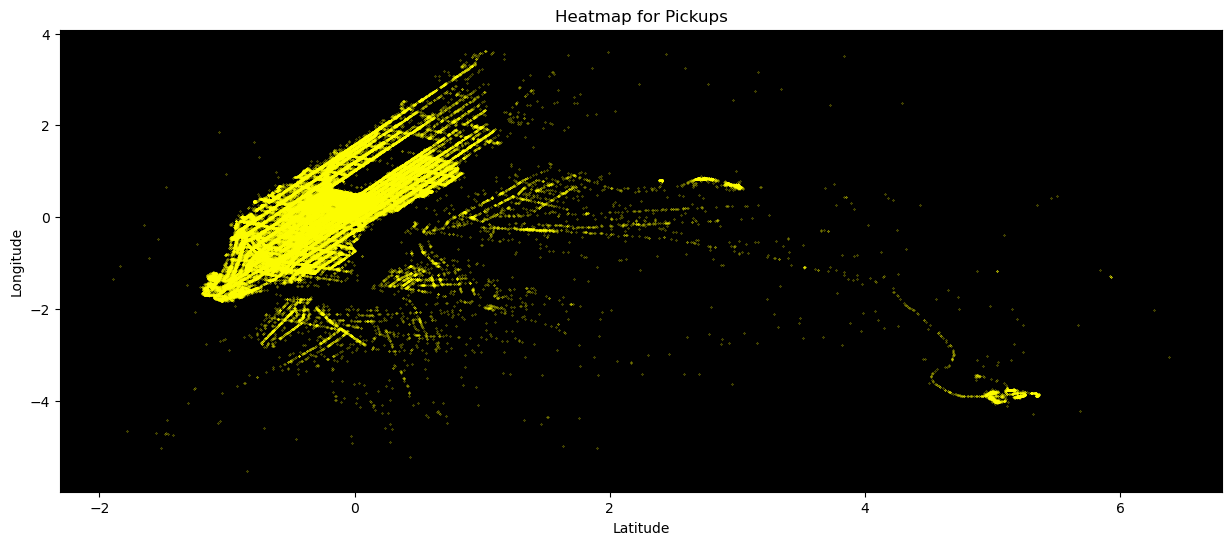

In [10]:
# plot the dataset on a scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,
                     figsize=(15,6))

ax.set_facecolor('k')
ax.scatter(scaled_sample_df['pickup_longitude'],scaled_sample_df['pickup_latitude'],s=0.05,color='yellow')
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

In [11]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

In [13]:
df_reader = pd.read_csv(data, chunksize=100000)

In [14]:
# train the standard scaler

scaler = StandardScaler()

for chunk in df_reader:
    # fit the scaler
    scaler.partial_fit(chunk)

In [15]:
scaler

StandardScaler()

In [16]:
# get the scaler std and mean

print("The mean values are ", scaler.mean_)
print("The sigma values are ", scaler.scale_ )

The mean values are  [ 40.75107121 -73.9740618 ]
The sigma values are  [0.02722268 0.03675237]


In [17]:
def haversine_distance(lat1:float, lon1:float, lat2:float, lon2:float):
    """
    Calculate haversine distances between two points given their latitude and
    longitude coordinates
    """
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(
        dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    
    earth_radius = 3958.8
    distance = earth_radius * c
    return distance

In [18]:
def select_optimum_k(k_values):
    for k in k_values:
        
        mini_batch = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)

        df_reader = pd.read_csv(data, chunksize=100000)
        scaler = StandardScaler()

        for chunk in df_reader:
               # fit the scaler
            scaler.partial_fit(chunk)

        df_reader = pd.read_csv(data, chunksize=100000)
        for chunk in df_reader:
            # scale the chunk
            scaled_chunk = scaler.transform(chunk)
            # train the model
            mini_batch.partial_fit(scaled_chunk)
            
        # centroid values
        centroids = scaler.inverse_transform(mini_batch.cluster_centers_)
        # calculate distances
        all_distances = []
        for i in centroids:
            distances = []
            for j in centroids:
                distance = haversine_distance(i[0], i[1], j[0], j[1])
                distances.append(distance)
            all_distances.append(distances)
        all_distances = np.array(all_distances)
        # sort array
        sorted_distances = np.sort(all_distances, axis=-1)
        # nearby regions
        region_count = 8
        # selected distances
        selected_distances = sorted_distances[:, 1:region_count+1]
        # average distances
        avg_distances = selected_distances.mean(axis=1)
        # count averages that fit criteria
        counter = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).sum()
        percentage = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).mean()
        print(f"For {k} clusters, the number of nearby regions that fits criteria are {counter} and is {percentage * 100:.1f}% regions of total")

In [19]:
possible_k_values = np.arange(10,100,10)

possible_k_values

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [20]:
# select the optimum value of K

select_optimum_k(k_values=possible_k_values)

For 10 clusters, the number of nearby regions that fits criteria are 0 and is 0.0% regions of total
For 20 clusters, the number of nearby regions that fits criteria are 6 and is 30.0% regions of total
For 30 clusters, the number of nearby regions that fits criteria are 9 and is 30.0% regions of total
For 40 clusters, the number of nearby regions that fits criteria are 8 and is 20.0% regions of total
For 50 clusters, the number of nearby regions that fits criteria are 7 and is 14.0% regions of total
For 60 clusters, the number of nearby regions that fits criteria are 10 and is 16.7% regions of total
For 70 clusters, the number of nearby regions that fits criteria are 13 and is 18.6% regions of total
For 80 clusters, the number of nearby regions that fits criteria are 14 and is 17.5% regions of total
For 90 clusters, the number of nearby regions that fits criteria are 17 and is 18.9% regions of total


In [29]:

mini_batch = MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

df_reader = pd.read_csv(data, chunksize=100000)
scaler = StandardScaler()

for chunk in df_reader:
    # fit the scaler
    scaler.partial_fit(chunk)


df_reader = pd.read_csv(data, chunksize=100000)
for chunk in df_reader:
    # scale the chunk
    scaled_chunk = scaler.transform(chunk)
    # train the model
    mini_batch.partial_fit(scaled_chunk)
    
# centroid values
centroids = mini_batch.cluster_centers_

centroids

array([[ 1.94149572,  0.6614905 ],
       [-0.13980742, -0.07596928],
       [-1.99721801,  1.44528196],
       [-3.83635934,  5.15118517],
       [-1.16343866, -0.81227839],
       [ 0.42137614, -0.13488625],
       [ 0.72209007,  2.8610836 ],
       [-0.52924948, -0.39015448],
       [ 1.07003845,  0.56520318],
       [-2.24451716, -0.3303071 ],
       [-1.00166487, -0.4036074 ],
       [ 1.16185672, -0.10175947],
       [-0.08902033, -0.55920139],
       [ 0.31820801,  1.59046972],
       [-0.04552948, -0.25372558],
       [ 0.20846098, -0.35389222],
       [-1.31780812,  0.52314378],
       [ 2.79102906,  0.81932304],
       [ 0.28712745,  0.12935608],
       [ 0.73099844, -0.27639436],
       [-1.53772972, -1.0082658 ],
       [ 0.67692302,  0.39844824],
       [-0.76412025, -0.74701446],
       [ 1.62394033,  0.1378545 ],
       [-3.07963657, -0.43385234],
       [ 0.3506753 , -0.54018812],
       [-0.57100818, -0.17842182],
       [-0.38830582, -0.76072368],
       [-2.66479788,

In [30]:
centroids = scaler.inverse_transform(mini_batch.cluster_centers_)

centroids.shape

centroids

array([[ 40.80392392, -73.94975046],
       [ 40.74726528, -73.97685385],
       [ 40.69670159, -73.92094427],
       [ 40.64663525, -73.78474354],
       [ 40.7193993 , -74.00391496],
       [ 40.7625422 , -73.97901919],
       [ 40.77072843, -73.8689102 ],
       [ 40.73666362, -73.9884009 ],
       [ 40.78020052, -73.95328925],
       [ 40.68996945, -73.98620137],
       [ 40.72380321, -73.98889533],
       [ 40.78270006, -73.9778017 ],
       [ 40.74864784, -73.99461378],
       [ 40.75973368, -73.91560827],
       [ 40.74983178, -73.98338682],
       [ 40.75674608, -73.98706818],
       [ 40.71519695, -73.95483503],
       [ 40.82705049, -73.94394974],
       [ 40.75888759, -73.96930766],
       [ 40.77097094, -73.98421995],
       [ 40.70921009, -74.01111796],
       [ 40.76949887, -73.95941789],
       [ 40.73026981, -74.00151635],
       [ 40.79527921, -73.96899532],
       [ 40.66723527, -73.9900069 ],
       [ 40.76061753, -73.993915  ],
       [ 40.73552684, -73.98061923],
 

In [23]:
# calculate distances
all_distances = []
for i in centroids:
    distances = []
    for j in centroids:
        distance = haversine_distance(i[0], i[1], j[0], j[1])
        distances.append(distance)
    all_distances.append(distances)
all_distances = np.array(all_distances)

In [24]:
all_distances.shape

(30, 30)

In [25]:
# sort array
sorted_distances = np.sort(all_distances)

sorted_distances

array([[ 0.        ,  1.17046275,  1.62644497,  1.64956641,  2.07449605,
         2.43174071,  2.90442913,  3.2434477 ,  3.27565262,  3.53740885,
         3.78050229,  3.79970162,  3.96017252,  4.13108335,  4.16372256,
         4.48294461,  4.81099377,  4.99426451,  5.06830264,  5.16566196,
         5.765128  ,  5.90274144,  6.13628226,  6.49173393,  7.28986507,
         7.56031049,  8.10147619,  8.67613248,  9.67668877, 13.88381717],
       [ 0.        ,  0.38520824,  0.83466661,  0.84554574,  0.89491143,
         0.93453618,  0.9497229 ,  1.06161155,  1.28395435,  1.39786924,
         1.68267844,  1.73935963,  1.74527216,  1.78680442,  2.1291437 ,
         2.39049179,  2.44883646,  2.49771118,  2.58829318,  3.18314532,
         3.31936779,  3.34286722,  3.9889529 ,  4.16372256,  4.5581976 ,
         4.84586092,  5.57235103,  5.77518367,  5.87736576, 12.23197903],
       [ 0.        ,  2.18727182,  2.33312628,  3.45017867,  3.60190277,
         4.0214796 ,  4.11861947,  4.15208245,  4

In [26]:
# nearby regions
region_count = 8
# selected distances
selected_distances = sorted_distances[:, 1:region_count+1]
# average distances
avg_distances = selected_distances.mean(axis=1)

In [27]:
selected_distances

array([[ 1.17046275,  1.62644497,  1.64956641,  2.07449605,  2.43174071,
         2.90442913,  3.2434477 ,  3.27565262],
       [ 0.38520824,  0.83466661,  0.84554574,  0.89491143,  0.93453618,
         0.9497229 ,  1.06161155,  1.28395435],
       [ 2.18727182,  2.33312628,  3.45017867,  3.60190277,  4.0214796 ,
         4.11861947,  4.15208245,  4.36409798],
       [ 7.93169228,  9.36855262,  9.64097158, 10.09315318, 10.39482286,
        10.56112547, 10.85291444, 10.97425053],
       [ 0.76151738,  0.79871063,  0.84332096,  1.44318852,  1.46133899,
         1.65214612,  2.07874566,  2.23510174],
       [ 0.56752242,  0.58123428,  0.64283085,  0.79082054,  0.90747837,
         1.06161155,  1.13278419,  1.26008803],
       [ 2.55912324,  3.86816694,  4.46322742,  4.73679633,  4.81099377,
         5.31727743,  5.50409572,  5.52711246],
       [ 0.41490598,  0.76069091,  0.8165102 ,  0.88895546,  0.88962214,
         0.94694645,  0.9497229 ,  1.38933145],
       [ 0.80596199,  1.29403148

In [28]:
avg_distances

array([2.29703004, 0.89876963, 3.52859488, 9.97718537, 1.40925875,
       0.86804628, 4.59834916, 0.88208569, 1.59066958, 2.26646269,
       1.22665091, 1.39749766, 0.87992819, 2.71684773, 0.78007248,
       0.79721075, 2.27350129, 3.6456581 , 1.02570843, 1.1165675 ,
       1.93409239, 1.34924415, 1.09340781, 1.82286886, 3.30517047,
       0.98753376, 1.02024965, 1.07522903, 2.8928434 , 2.14386745])

In [77]:
((avg_distances >= 1.0) & (avg_distances <= 1.5)).mean()

np.float64(0.3)

In [31]:
((avg_distances >= 1.0) & (avg_distances <= 1.5)).sum()

np.int64(9)

# Clustering

In [32]:
df_reader = pd.read_csv(data, chunksize=100000)

In [33]:
# train the model

mini_batch = MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

for chunk in df_reader:
    # scale the chunk
    scaled_chunk = scaler.transform(chunk)
    # train the model
    mini_batch.partial_fit(scaled_chunk)

In [34]:
mini_batch

MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

In [35]:
# centroids of the model

mini_batch.cluster_centers_

array([[ 1.94149572,  0.6614905 ],
       [-0.13980742, -0.07596928],
       [-1.99721801,  1.44528196],
       [-3.83635934,  5.15118517],
       [-1.16343866, -0.81227839],
       [ 0.42137614, -0.13488625],
       [ 0.72209007,  2.8610836 ],
       [-0.52924948, -0.39015448],
       [ 1.07003845,  0.56520318],
       [-2.24451716, -0.3303071 ],
       [-1.00166487, -0.4036074 ],
       [ 1.16185672, -0.10175947],
       [-0.08902033, -0.55920139],
       [ 0.31820801,  1.59046972],
       [-0.04552948, -0.25372558],
       [ 0.20846098, -0.35389222],
       [-1.31780812,  0.52314378],
       [ 2.79102906,  0.81932304],
       [ 0.28712745,  0.12935608],
       [ 0.73099844, -0.27639436],
       [-1.53772972, -1.0082658 ],
       [ 0.67692302,  0.39844824],
       [-0.76412025, -0.74701446],
       [ 1.62394033,  0.1378545 ],
       [-3.07963657, -0.43385234],
       [ 0.3506753 , -0.54018812],
       [-0.57100818, -0.17842182],
       [-0.38830582, -0.76072368],
       [-2.66479788,

In [36]:
scaler.inverse_transform(mini_batch.cluster_centers_)

array([[ 40.80392392, -73.94975046],
       [ 40.74726528, -73.97685385],
       [ 40.69670159, -73.92094427],
       [ 40.64663525, -73.78474354],
       [ 40.7193993 , -74.00391496],
       [ 40.7625422 , -73.97901919],
       [ 40.77072843, -73.8689102 ],
       [ 40.73666362, -73.9884009 ],
       [ 40.78020052, -73.95328925],
       [ 40.68996945, -73.98620137],
       [ 40.72380321, -73.98889533],
       [ 40.78270006, -73.9778017 ],
       [ 40.74864784, -73.99461378],
       [ 40.75973368, -73.91560827],
       [ 40.74983178, -73.98338682],
       [ 40.75674608, -73.98706818],
       [ 40.71519695, -73.95483503],
       [ 40.82705049, -73.94394974],
       [ 40.75888759, -73.96930766],
       [ 40.77097094, -73.98421995],
       [ 40.70921009, -74.01111796],
       [ 40.76949887, -73.95941789],
       [ 40.73026981, -74.00151635],
       [ 40.79527921, -73.96899532],
       [ 40.66723527, -73.9900069 ],
       [ 40.76061753, -73.993915  ],
       [ 40.73552684, -73.98061923],
 

In [37]:
# perform predictions and assign clusters

sample_predictions = mini_batch.predict(scaled_sample_df)

sample_predictions.shape

(166500,)

In [38]:
np.unique(sample_predictions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)

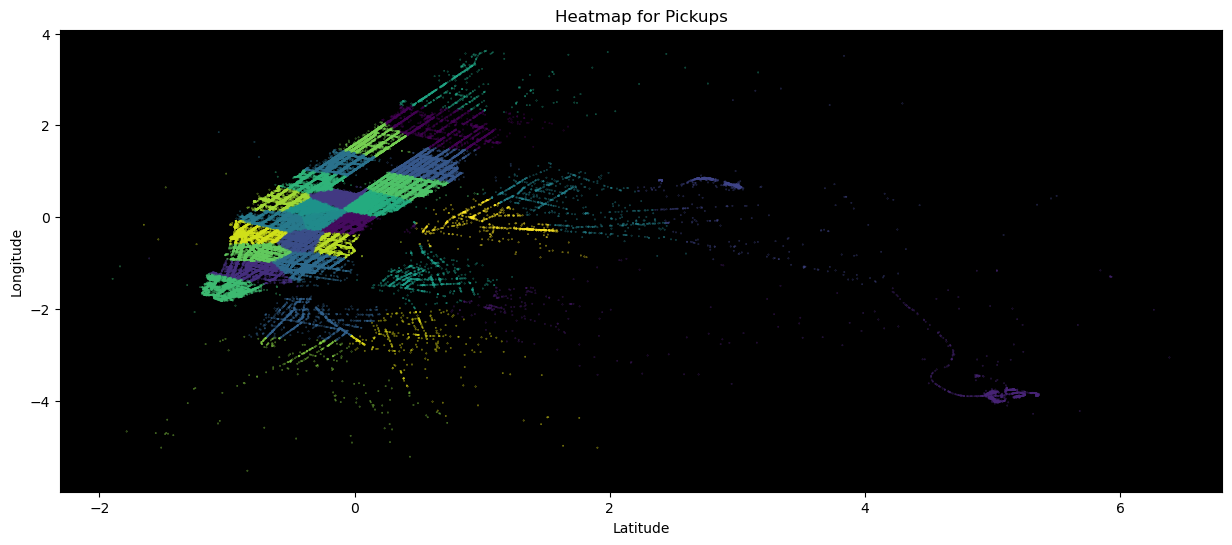

In [39]:
# plot the dataset on a scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,
                     figsize=(15,6))

ax.set_facecolor('k')
ax.scatter(scaled_sample_df['pickup_longitude'],scaled_sample_df['pickup_latitude'],
           s=0.05,c=sample_predictions)
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

plt.show()